In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, classification_report,recall_score,precision_score,roc_auc_score,roc_curve
import tensorflow as tf
from tensorflow import keras as kr
from keras import metrics

## Summary
add sum ary of the notebook for interpreatabilty
>>>>>>>>>>>>>>>>

# 1. Data Cleaning

In [2]:
# load the data
player_track = pd.read_csv('data/PlayerTrackData.csv')

In [3]:
play_list = pd.read_csv('data/PlayList.csv')

In [4]:
injury_data = pd.read_csv('data/InjuryRecord.csv')

In [5]:
# Check the header and few rows of data for injury record
injury_data.head()

PlayerKey   GameID     PlayKey BodyPart    Surface  DM_M1  DM_M7  DM_M28  \
0      39873  39873-4  39873-4-32     Knee  Synthetic      1      1       1   
1      46074  46074-7  46074-7-26     Knee    Natural      1      1       0   
2      36557  36557-1  36557-1-70    Ankle  Synthetic      1      1       1   
3      46646  46646-3  46646-3-30    Ankle    Natural      1      0       0   
4      43532  43532-5  43532-5-69    Ankle  Synthetic      1      1       1   

   DM_M42  
0       1  
1       0  
2       1  
3       0  
4       1

In [6]:
#total rows in the injury record
print("Total number of rows:", len(injury_data))

#Stats of injury record
count_unique_injury = pd.DataFrame({
    'count': injury_data.count(),
    'unique': injury_data.nunique()
})

print(count_unique_injury)

Total number of rows: 105
           count  unique
PlayerKey    105     100
GameID       105     104
PlayKey       77      76
BodyPart     105       5
Surface      105       2
DM_M1        105       1
DM_M7        105       2
DM_M28       105       2
DM_M42       105       2


In [7]:
#Check injury record data for null values
injury_data.isnull().sum()

PlayerKey     0
GameID        0
PlayKey      28
BodyPart      0
Surface       0
DM_M1         0
DM_M7         0
DM_M28        0
DM_M42        0
dtype: int64

In [8]:
# Create a dictionary to store the last PlayKey for each GameID
last_play_dict = play_list.groupby('GameID')['PlayKey'].last().to_dict()

# Loop through each row in the injury_record DataFrame
for index, row in injury_data.iterrows():
    if pd.isnull(row['PlayKey']):
        # If PlayKey is missing, fill it with the last recorded PlayKey for that GameID
        injury_data.at[index, 'PlayKey'] = last_play_dict.get(row['GameID'])

In [9]:
# Check injury data for nulls
injury_data.isnull().sum()

PlayerKey    0
GameID       0
PlayKey      0
BodyPart     0
Surface      0
DM_M1        0
DM_M7        0
DM_M28       0
DM_M42       0
dtype: int64

In [10]:
# remove the DM_M1, DM_M7, DM_M28, DM_M42 make a single column injury
# if any of DM_M1, DM_M7, DM_M28, DM_M42 columns value is 1 that means the player is injured making injury as 1

injury_data['Injury'] = (injury_data[['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']].any(axis=1)).astype(int)

In [11]:
# drop the columns DM_M1, DM_M7, DM_M28, DM_M42
# injury_data = injury_data.drop(columns=['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])

In [12]:
injury_data.head()

PlayerKey   GameID     PlayKey BodyPart    Surface  DM_M1  DM_M7  DM_M28  \
0      39873  39873-4  39873-4-32     Knee  Synthetic      1      1       1   
1      46074  46074-7  46074-7-26     Knee    Natural      1      1       0   
2      36557  36557-1  36557-1-70    Ankle  Synthetic      1      1       1   
3      46646  46646-3  46646-3-30    Ankle    Natural      1      0       0   
4      43532  43532-5  43532-5-69    Ankle  Synthetic      1      1       1   

   DM_M42  Injury  
0       1       1  
1       0       1  
2       1       1  
3       0       1  
4       1       1

In [13]:
play_list.head()

PlayerKey   GameID    PlayKey RosterPosition  PlayerDay  PlayerGame  \
0      26624  26624-1  26624-1-1    Quarterback          1           1   
1      26624  26624-1  26624-1-2    Quarterback          1           1   
2      26624  26624-1  26624-1-3    Quarterback          1           1   
3      26624  26624-1  26624-1-4    Quarterback          1           1   
4      26624  26624-1  26624-1-5    Quarterback          1           1   

  StadiumType  FieldType  Temperature         Weather PlayType  \
0     Outdoor  Synthetic           63  Clear and warm     Pass   
1     Outdoor  Synthetic           63  Clear and warm     Pass   
2     Outdoor  Synthetic           63  Clear and warm     Rush   
3     Outdoor  Synthetic           63  Clear and warm     Rush   
4     Outdoor  Synthetic           63  Clear and warm     Pass   

   PlayerGamePlay Position PositionGroup  
0               1       QB            QB  
1               2       QB            QB  
2               3       QB            QB  
3               4       QB            QB  
4               5       QB            QB

In [14]:
#total rows in the play list
print("Total number of rows:", len(play_list))

#Stats of play list
count_unique_play_list = pd.DataFrame({
    'count': play_list.count(),
    'unique': play_list.nunique()
})

print(count_unique_play_list)

Total number of rows: 267005
                 count  unique
PlayerKey       267005     250
GameID          267005    5712
PlayKey         267005  267005
RosterPosition  267005      10
PlayerDay       267005     215
PlayerGame      267005      32
StadiumType     250095      29
FieldType       267005       2
Temperature     267005      79
Weather         248314      63
PlayType        266638      11
PlayerGamePlay  267005     102
Position        267005      23
PositionGroup   267005      10


In [15]:
#Check play list data for null values
play_list.isnull().sum()

PlayerKey             0
GameID                0
PlayKey               0
RosterPosition        0
PlayerDay             0
PlayerGame            0
StadiumType       16910
FieldType             0
Temperature           0
Weather           18691
PlayType            367
PlayerGamePlay        0
Position              0
PositionGroup         0
dtype: int64

In [16]:
# Get unique values for Stadium Type
play_list['StadiumType'].unique()

array(['Outdoor', 'Indoors', 'Oudoor', 'Outdoors', 'Open', 'Closed Dome',
       'Domed, closed', nan, 'Dome', 'Indoor', 'Domed',
       'Retr. Roof-Closed', 'Outdoor Retr Roof-Open', 'Retractable Roof',
       'Ourdoor', 'Indoor, Roof Closed', 'Retr. Roof - Closed', 'Bowl',
       'Outddors', 'Retr. Roof-Open', 'Dome, closed', 'Indoor, Open Roof',
       'Domed, Open', 'Domed, open', 'Heinz Field', 'Cloudy',
       'Retr. Roof - Open', 'Retr. Roof Closed', 'Outdor', 'Outside'],
      dtype=object)

In [17]:
# Categorical Grouping for Stadium Type 
indoor_ar = ['Indoors', 'Indoor', 'Retractable Roof']
outdoor_ar = ['Outdoor', 'Oudoor', 'Outdoors', 'Outside', 'Ourdoor', 'Outdor', 'Outddors', 'Cloudy', 'Heinz Field', 'Bowl']
roof_open = ['Open', 'Indoor, Open Roof','Retr. Roof-Open', 'Domed, Open', 'Domed, open', 'Outdoor Retr Roof-Open', 'Retr. Roof - Open']
roof_closed = ['Closed Dome', 'Domed, closed', 'Dome', 'Domed', 'Retr. Roof-Closed', 'Dome, closed', 'Retr. Roof - Closed', 'Indoor, Roof Closed', 'Retr. Roof Closed']

play_list['StadiumType'] = play_list['StadiumType'].replace(outdoor_ar, 'Outdoors')
play_list['StadiumType'] = play_list['StadiumType'].replace(indoor_ar, 'Indoors')
play_list['StadiumType'] = play_list['StadiumType'].replace(roof_open, 'Open Roof')
play_list['StadiumType'] = play_list['StadiumType'].replace(roof_closed, 'Closed Roof')

In [18]:
# Get unique values for Weather
play_list['Weather'].unique()

array(['Clear and warm', 'Mostly Cloudy', 'Sunny', 'Clear', 'Cloudy',
       'Cloudy, fog started developing in 2nd quarter', 'Rain',
       'Partly Cloudy', 'Mostly cloudy', 'Cloudy and cold',
       'Cloudy and Cool', 'Rain Chance 40%', 'Controlled Climate',
       'Sunny and warm', 'Partly cloudy', 'Clear and Cool',
       'Clear and cold', 'Sunny and cold', 'Indoor', nan, 'Partly Sunny',
       'N/A (Indoors)', 'Mostly Sunny', 'Indoors', 'Clear Skies',
       'Partly sunny', 'Showers', 'N/A Indoor', 'Sunny and clear', 'Snow',
       'Scattered Showers', 'Party Cloudy', 'Clear skies',
       'Rain likely, temps in low 40s.', 'Hazy', 'Partly Clouidy',
       'Sunny Skies', 'Overcast', 'Cloudy, 50% change of rain', 'Fair',
       'Light Rain', 'Partly clear', 'Mostly Coudy', '10% Chance of Rain',
       'Cloudy, chance of rain', 'Heat Index 95',
       'Sunny, highs to upper 80s', 'Sun & clouds',
       'Heavy lake effect snow', 'Mostly sunny', 'Cloudy, Rain',
       'Sunny, Windy', '

In [19]:
# Categorical Grouping for Weather 
clear_ar = ['Clear and warm', 'Sunny', 'Clear', 'Sunny and warm', 'Clear and Cool', 'Clear and cold', 'Sunny and cold', 'Partly Sunny', 
            'Sunny and clear', 'Partly sunny', 'Mostly Sunny', 'Clear Skies', 'Clear skies', 'Sunny Skies', 'Fair', 'Partly clear', 'Heat Index 95',
            'Sunny, highs to upper 80s', 'Mostly sunny', 'Sunny, Windy', 'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny', 
            'Clear to Partly Cloudy', 'Cold']

cloudy_ar = ['Mostly Cloudy', 'Cloudy', 'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy', 'Mostly cloudy', 'Cloudy and cold', 
             'Cloudy and Cool', 'Partly cloudy', 'Party Cloudy', 'Partly Clouidy', 'Hazy', 'Overcast', 'Mostly Coudy', 'Cloudy, 50% change of rain', 
             'Cloudy, chance of rain', 'Sun & clouds', 'cloudy', 'Coudy']

indoors_ar = ['Controlled Climate', 'Indoor', 'N/A (Indoors)', 'Indoors', 'N/A Indoor']

precipitation_ar = ['Rain', 'Rain Chance 40%', 'Showers', 'Snow', 'Scattered Showers', 'Rain likely, temps in low 40s.',  'Light Rain', 
                    '10% Chance of Rain', 'Heavy lake effect snow', 'Cloudy, Rain', 'Rainy', '30% Chance of Rain', 'Rain shower', 
                    'Cloudy, light snow accumulating 1-3"', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.']

play_list['Weather'] = play_list['Weather'].replace(clear_ar, 'Clear')
play_list['Weather'] = play_list['Weather'].replace(cloudy_ar, 'Cloudy')
play_list['Weather'] = play_list['Weather'].replace(indoors_ar, 'Indoors')
play_list['Weather'] = play_list['Weather'].replace(precipitation_ar, 'Precipitation')

In [20]:
# Null values for stadium type are filled with Outdoors, when Weather is not Indoors
play_list.loc[
    (play_list['StadiumType'].isnull()) & (play_list['Weather'] != 'Indoors'),
    'StadiumType'] = 'Outdoors'

In [21]:
# Null values for weather are filled with Indoors, when stadiums is Closed Roof or Indoors
play_list.loc[
    (play_list['Weather'].isnull()) & ((play_list['StadiumType'] =='Closed Roof') | (play_list['StadiumType']=='Indoors')),
    'Weather'] = 'Indoors'

In [22]:
# Null values for weather are filled with Cloudy or Clear, when stadiums is Open Roof or Outdoors and based on Temperature
play_list.loc[
(play_list['Weather'].isnull()) & 
((play_list['StadiumType'] =='Open Roof') | (play_list['StadiumType']=='Outdoors')) &
(play_list['Temperature'] < 68),'Weather'] = 'Cloudy'

In [23]:
play_list.loc[
(play_list['Weather'].isnull()) & 
((play_list['StadiumType'] =='Open Roof') | (play_list['StadiumType']=='Outdoors')) &
(play_list['Temperature'] >= 68),'Weather'] = 'Clear'

In [24]:
play_list['Temperature'].unique()

array([  63,   85,   84,   61,   76,   73,   56,   62,   48,   66,   47,
         55,   42,   35,   13,   97,   68,   65,   45,   44,   46,   40,
         54,   53,   82,   33,   70,   52,   79,   57,   72,   69, -999,
         67,   71,   86,   90,   77,   39,   78,   60,   50,   43,   74,
         34,   89,   23,   92,   75,   81,   36,   88,   49,   80,   22,
         87,   58,   16,   51,   64,   83,   41,   29,   19,   91,   38,
         25,   17,   28,   10,   37,   31,   11,   32,    9,   59,   24,
         27,   26], dtype=int64)

In [25]:
# Replace temp = -999 with 67 when stadium is Closed Roof and Indoors
play_list.loc[
    ((play_list['StadiumType'] == 'Closed Roof') | (play_list['StadiumType'] == 'Indoors')) & (play_list['Temperature'] == -999),
    'Temperature'] = 67

In [26]:
# Compute the mean of the temperature for the outdoor games other than games with temperature -999
outdoor_temp_mean = play_list.loc[((play_list['StadiumType'] == 'Roof Open') | (play_list['StadiumType'] == 'Outdoors')) & (play_list['Temperature'] != -999)]['Temperature'].median()

In [27]:
#Fill temp = -999 with mean of outdoor game temps
play_list.loc[play_list['Temperature'] == -999,'Temperature'] = int(outdoor_temp_mean)

In [28]:
play_list['PlayType'].unique()

array(['Pass', 'Rush', '0', nan, 'Kickoff', 'Kickoff Not Returned',
       'Field Goal', 'Punt', 'Punt Not Returned', 'Punt Returned',
       'Kickoff Returned', 'Extra Point'], dtype=object)

In [29]:
# Replace 0's with nan
play_list['PlayType'] = play_list['PlayType'].replace('0', np.nan)
# Fill the NaN values with Forward Fill
play_list['PlayType'] = play_list['PlayType'].ffill()

In [30]:
play_list['Position'].unique()

array(['QB', 'Missing Data', 'WR', 'ILB', 'RB', 'DE', 'TE', 'FS', 'CB',
       'G', 'T', 'OLB', 'DT', 'SS', 'MLB', 'C', 'NT', 'DB', 'K', 'LB',
       'S', 'HB', 'P'], dtype=object)

In [31]:
# Replace Missing Data of Position by considering the RosterPosition
play_list.loc[(play_list['Position'] == 'Missing Data') & (play_list['RosterPosition'] == 'Quarterback'), 'Position'] = 'QB'
play_list.loc[(play_list['Position'] == 'Missing Data') & (play_list['RosterPosition'] == 'Tight End'), 'Position'] = 'TE'
play_list.loc[(play_list['Position'] == 'Missing Data') & (play_list['RosterPosition'] == 'Linebacker'), 'Position'] = 'LB'
play_list.loc[(play_list['Position'] == 'Missing Data') & (play_list['RosterPosition'] == 'Running Back'), 'Position'] = 'RB'
play_list.loc[(play_list['Position'] == 'Missing Data') & (play_list['RosterPosition'] == 'Cornerback'), 'Position'] = 'CB'
play_list.loc[(play_list['Position'] == 'Missing Data') & (play_list['RosterPosition'] == 'Wide Receiver'), 'Position'] = 'WR'

In [32]:
play_list['PositionGroup'].unique()

array(['QB', 'Missing Data', 'WR', 'LB', 'RB', 'DL', 'TE', 'DB', 'OL',
       'SPEC'], dtype=object)

In [33]:
# Replace Missing Data of PositionGroup by considering the RosterPosition
play_list.loc[(play_list['PositionGroup'] == 'Missing Data') & (play_list['RosterPosition'] == 'Quarterback'), 'PositionGroup'] = 'QB'
play_list.loc[(play_list['PositionGroup'] == 'Missing Data') & (play_list['RosterPosition'] == 'Tight End'), 'PositionGroup'] = 'TE'
play_list.loc[(play_list['PositionGroup'] == 'Missing Data') & (play_list['RosterPosition'] == 'Linebacker'), 'PositionGroup'] = 'LB'
play_list.loc[(play_list['PositionGroup'] == 'Missing Data') & (play_list['RosterPosition'] == 'Running Back'), 'PositionGroup'] = 'RB'
play_list.loc[(play_list['PositionGroup'] == 'Missing Data') & (play_list['RosterPosition'] == 'Cornerback'), 'PositionGroup'] = 'DB'
play_list.loc[(play_list['PositionGroup'] == 'Missing Data') & (play_list['RosterPosition'] == 'Wide Receiver'), 'PositionGroup'] = 'WR'
play_list.loc[(play_list['PositionGroup'] == 'Missing Data') & (play_list['RosterPosition'] == 'Offensive Lineman'), 'PositionGroup'] = 'OL'

In [34]:
play_list['RosterPosition'].unique()

array(['Quarterback', 'Wide Receiver', 'Linebacker', 'Running Back',
       'Defensive Lineman', 'Tight End', 'Safety', 'Cornerback',
       'Offensive Lineman', 'Kicker'], dtype=object)

In [35]:
player_track.head()

PlayKey  time                 event      x      y     dir   dis       o  \
0  26624-1-1   0.0  huddle_start_offense  87.46  28.93  288.24  0.01  262.33   
1  26624-1-1   0.1                   NaN  87.45  28.92  283.91  0.01  261.69   
2  26624-1-1   0.2                   NaN  87.44  28.92  280.40  0.01  261.17   
3  26624-1-1   0.3                   NaN  87.44  28.92  278.79  0.01  260.66   
4  26624-1-1   0.4                   NaN  87.44  28.92  275.44  0.01  260.27   

      s  
0  0.13  
1  0.12  
2  0.12  
3  0.10  
4  0.09

In [36]:
#total rows in the injury set
print("Total number of rows:", len(player_track))

#See baseline stats of injury record
count_unique_player_track = pd.DataFrame({
    'count': player_track.count(),
    'unique': player_track.nunique()
})

print(count_unique_player_track)

Total number of rows: 76366748
            count  unique
PlayKey  76366748  266960
time     76366748    1870
event     1839873      80
x        76366748   14463
y        76366748    8546
dir      76366746   36001
dis      76366748     325
o        76366746   36001
s        76366748    1154


In [37]:
#Check injury data for nulls
player_track.isnull().sum()

PlayKey           0
time              0
event      74526875
x                 0
y                 0
dir               2
dis               0
o                 2
s                 0
dtype: int64

In [38]:
# forward filling null values
player_track['event'] = player_track['event'].ffill()

In [39]:
# Creating a new df with grouped playkey with their average distance and speed to reduce data points as the data is big
grouped_data_tracker = player_track.groupby('PlayKey').agg(
    total_distance=('dis', 'sum'),
    average_speed=('s', 'mean')
).reset_index()

In [40]:
grouped_data_tracker.head()

PlayKey  total_distance  average_speed
0   26624-1-1           16.83       0.535753
1  26624-1-10           17.07       0.576304
2  26624-1-11           31.20       0.795772
3  26624-1-12           14.70       0.349692
4  26624-1-13           13.26       0.427109

# 2. Exploratory Data Analysis

In [41]:
# Loading cleaned data sets
# play_list = pd.read_csv(r'C:\Users\Anurodh\CSE-805 Project\Charisma\C_play_list.csv')
# injury_data = pd.read_csv(r'C:\Users\Anurodh\CSE-805 Project\Charisma\C_injury_data.csv')
# grouped_data_tracker = pd.read_csv(r'C:\Users\Anurodh\CSE-805 Project\Charisma\C_grouped_data.csv')

In [42]:
# Merging (left) injury and playlist data set on 'PlayerKey', 'GameID', 'PlayKey' 
injury_playList = pd.merge(injury_data, play_list, on=['PlayerKey', 'GameID', 'PlayKey'], how='left')

In [43]:
# Checking total rows in the injury playlist merge
print("Total number of rows:", len(injury_playList))

# Stats of injury playlist merge
count_unique_injury_play = pd.DataFrame({
    'count': injury_playList.count(),
    'unique': injury_playList.nunique()
})

print(count_unique_injury_play)

Total number of rows: 105
                count  unique
PlayerKey         105     100
GameID            105     104
PlayKey           105     104
BodyPart          105       5
Surface           105       2
DM_M1             105       1
DM_M7             105       2
DM_M28            105       2
DM_M42            105       2
Injury            105       1
RosterPosition    105       8
PlayerDay         105      58
PlayerGame        105      25
StadiumType       105       4
FieldType         105       2
Temperature       105      44
Weather           105       4
PlayType          105       9
PlayerGamePlay    105      54
Position          105      15
PositionGroup     105       7


In [44]:
# Check injury playlist merge data for null values
injury_playList.isnull().sum()

PlayerKey         0
GameID            0
PlayKey           0
BodyPart          0
Surface           0
DM_M1             0
DM_M7             0
DM_M28            0
DM_M42            0
Injury            0
RosterPosition    0
PlayerDay         0
PlayerGame        0
StadiumType       0
FieldType         0
Temperature       0
Weather           0
PlayType          0
PlayerGamePlay    0
Position          0
PositionGroup     0
dtype: int64

Text(0, 0.5, 'Count of Affected Players')

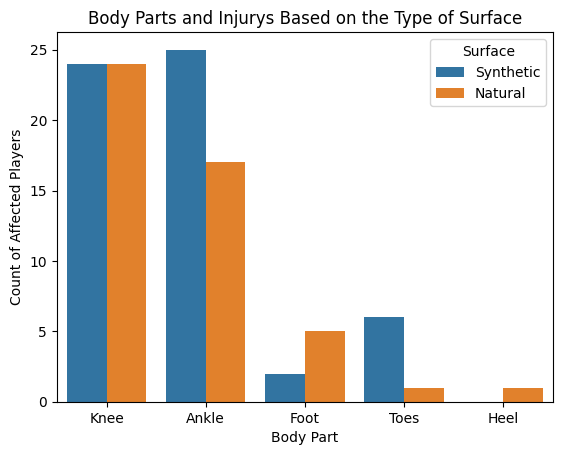

In [45]:
# Frequency chart for bodypart wrt 'Surface'
sns.countplot(data=injury_playList, x='BodyPart', hue= 'Surface',  order = injury_playList['BodyPart'].value_counts().index)
plt.title("Body Parts and Injurys Based on the Type of Surface");
plt.xlabel("Body Part")
plt.ylabel("Count of Affected Players")

### Graph Interpretation

This graph shows the distribution of counts categorized by **BodyPart** and **Surface** (Synthetic vs. Natural):

1. **Knee**: Equal counts on both surfaces.
2. **Ankle**: Higher counts on synthetic surfaces.
3. **Foot**: Slightly higher counts on natural surfaces.
4. **Toes**: Only occur on synthetic surfaces.
5. **Heel**: Only occur on natural surfaces, with minimal counts.

**Key Takeaways**:
- **Ankle injuries** are notably higher on synthetic surfaces.
- **Toes injuries** are exclusive to synthetic surfaces, while **heel injuries** are exclusive to natural surfaces.
- The **knee** is equally affected on both surfaces.


Text(0, 0.5, 'Count of Affected Players')

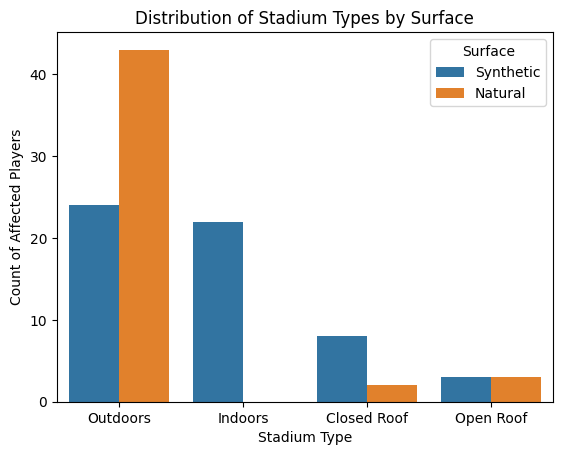

In [46]:
# Frequency chart for StadiumType wrt 'Surface'
sns.countplot(data=injury_playList, x='StadiumType', hue= 'Surface', order = injury_playList['StadiumType'].value_counts().index)
plt.title("Distribution of Stadium Types by Surface");
plt.xlabel("Stadium Type")
plt.ylabel("Count of Affected Players")

### Graph Interpretation: Count of Stadium Types by Surface

This barplot shows the frequency distribution of **StadiumType** categorized by **Surface** (Synthetic and Natural):

1. **Outdoors**:
   - Most frequent stadium type.
   - A significantly higher count on natural surfaces compared to synthetic surfaces.
2. **Indoors**:
   - All occurrences are on synthetic surfaces.
3. **Closed Roof**:
   - More occurrences on synthetic surfaces, with very few on natural surfaces.
4. **Open Roof**:
   - Rare occurrences, with both synthetic and natural surfaces equally represented.

**Key Takeaways**:
- **Outdoors** stadiums have the highest counts, with a strong preference for natural surfaces.
- **Indoors** and **Closed Roof** stadiums are predominantly synthetic.
- **Open Roof** stadiums are uncommon and evenly split between surface types.


Text(0, 0.5, 'Count of Affected Players')

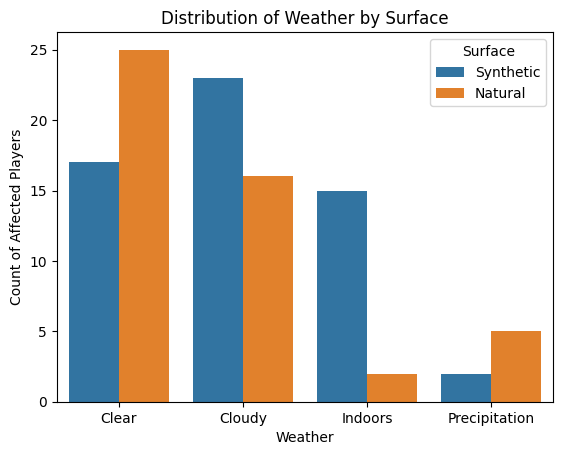

In [47]:
# Frequency plot wrt 'Weather' and Surface
sns.countplot(data=injury_playList, x='Weather', hue= 'Surface', order = injury_playList['Weather'].value_counts().index)
plt.title("Distribution of Weather by Surface");
plt.xlabel("Weather")
plt.ylabel("Count of Affected Players")

Text(0, 0.5, 'Count of Affected Players')

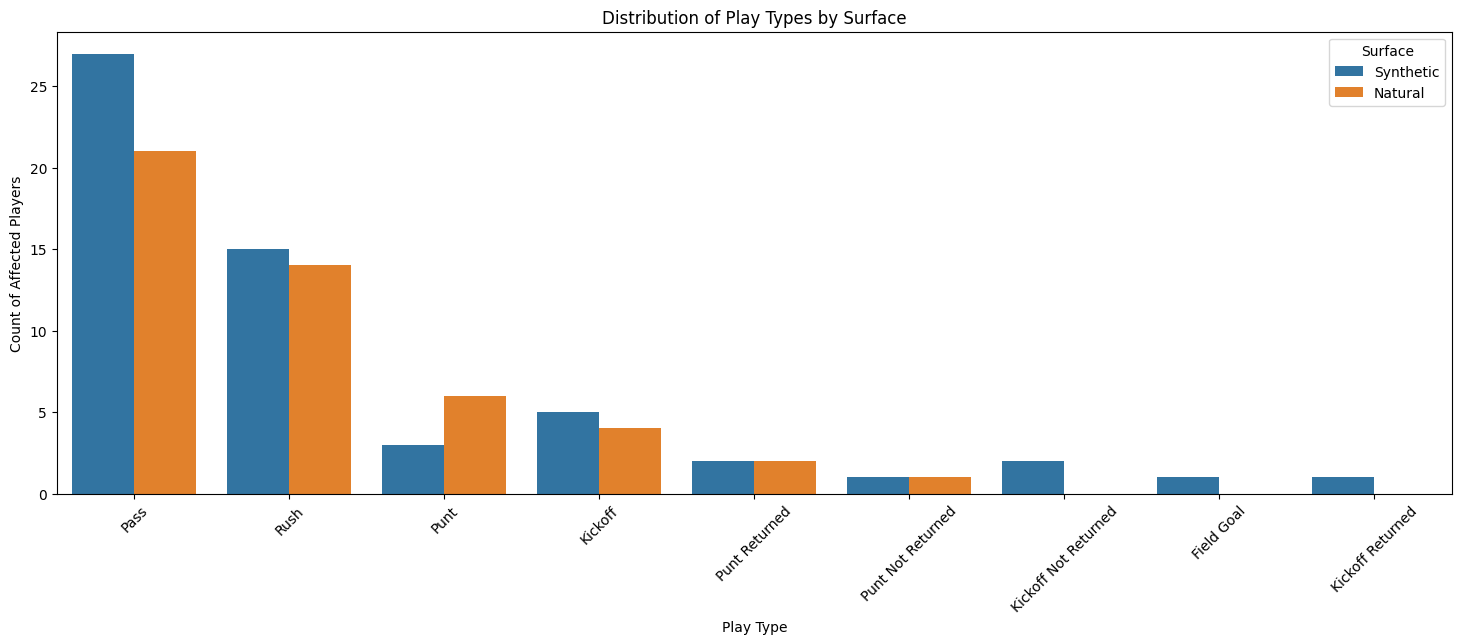

In [48]:
# Distribution of Play Types by Surface using frequency chart
plt.figure(figsize=(18, 6))
plt.xticks(rotation=45)
sns.countplot(data=injury_playList, x='PlayType', hue= 'Surface', order = injury_playList['PlayType'].value_counts().index)
plt.title("Distribution of Play Types by Surface");
plt.xlabel("Play Type")
plt.ylabel("Count of Affected Players")

### Graph Interpretation: Distribution of Play Types by Surface (Injuries)

This barplot shows the distribution of **Play Types** associated with **injuries**, categorized by **Surface** (Synthetic and Natural):

1. **Pass**:
   - The highest number of injuries occurs during passing plays on both synthetic and natural surfaces, with slightly more injuries on synthetic surfaces.

2. **Rush**:
   - The second-highest number of injuries occurs during rushing plays, with similar counts on synthetic and natural surfaces.

3. **Punt**:
   - Fewer injuries occur during punts, with slightly more on natural surfaces.

4. **Kickoff**:
   - Injuries during kickoffs are moderately frequent, with comparable counts on synthetic and natural surfaces.

5. **Punt Returned**:
   - Injuries are rare during punt returns and occur equally on both surfaces.

6. **Punt Not Returned**, **Field Goal**, **Kickoff Returned**:
   - The least injuries occur during these play types, primarily on synthetic surfaces.

**Key Takeaways**:
- **Pass** and **Rush** plays are associated with the highest number of injuries on both surfaces.
- Rare play types like **Punt Not Returned** and **Kickoff Returned** are primarily linked to synthetic surfaces.
- Natural surfaces see a slightly higher frequency of injuries during **Punt** plays compared to synthetic surfaces.
s compared to synthetic.


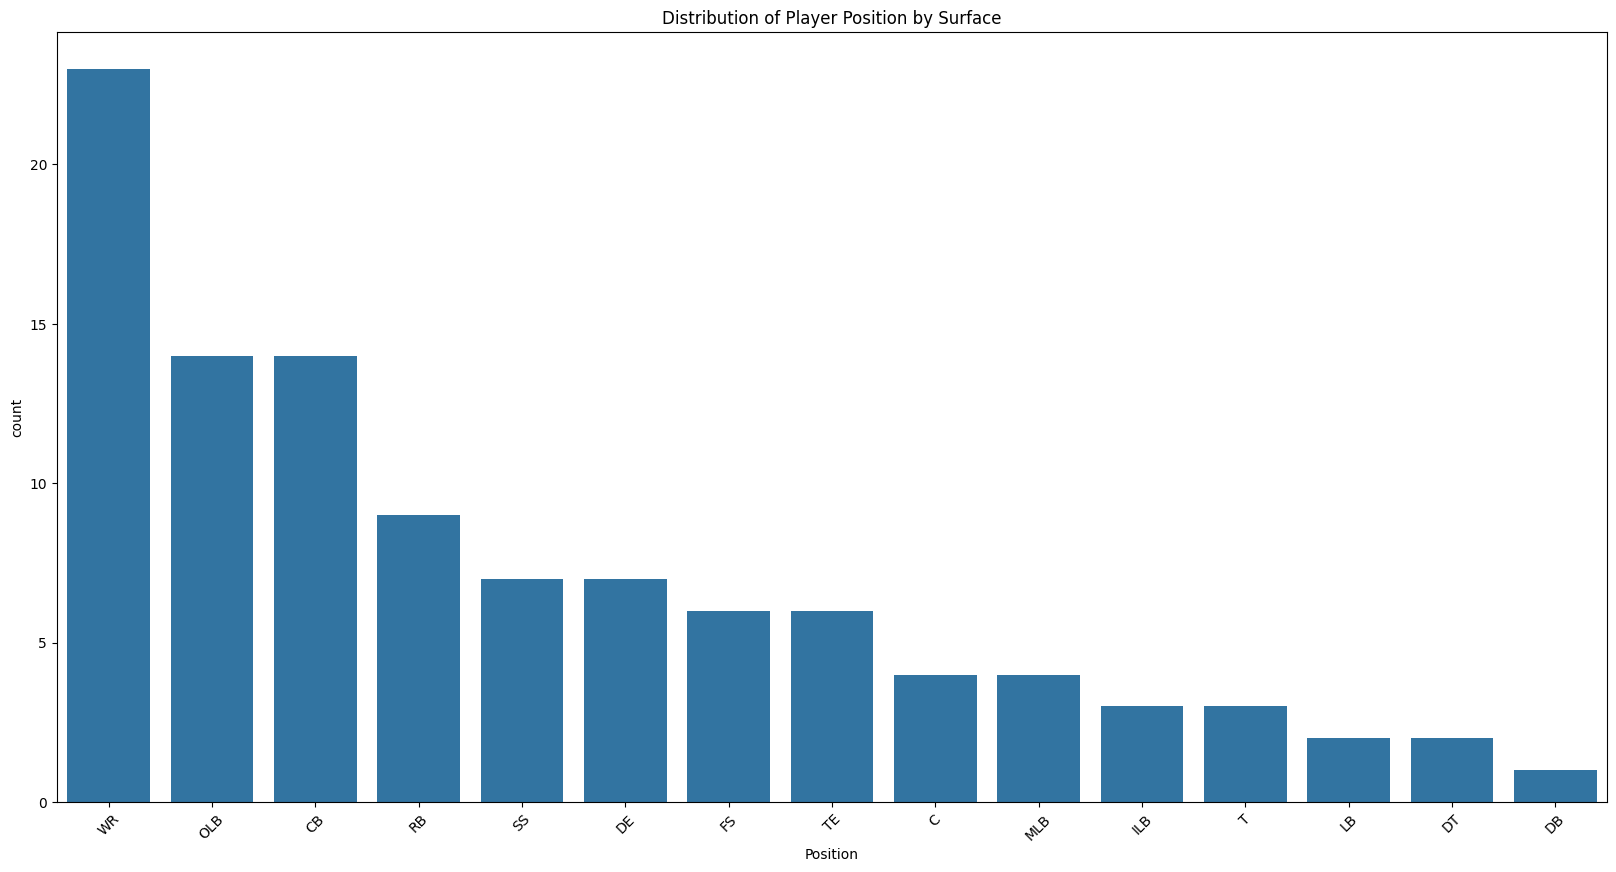

In [49]:
# Distribution of Player Position by Surface using frequency chart
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.countplot(data=injury_playList, x='Position', order = injury_playList['Position'].value_counts().index)
plt.title("Distribution of Player Position by Surface");

### Graph Interpretation: Distribution of Player Positions by Surface

This barplot illustrates the **distribution of injuries** across different **player positions**, categorized by **Surface**:

1. **Wide Receiver (WR)**:
   - WR has the highest number of injuries compared to all other positions.

2. **Quarterback (QB)** and **Cornerback (CB)**:
   - Both positions have a moderate injury count, following WR.

3. **Running Back (RB)**:
   - Injuries are slightly lower compared to QB and CB.

4. **Safety (SS)**, **Defensive End (DE)**, **Tight End (TE)**, and **Center (C)**:
   - These positions have a similar number of injuries, which are lower than RB but higher than others.

5. **Middle Linebacker (MLB)**, **Inside Linebacker (ILB)**, and **Tackle (T)**:
   - These positions experience fewer injuries compared to the above categories.

6. **Linebacker (LB)**, **Defensive Tackle (DT)**, and **Defensive Back (DB)**:
   - These positions have the fewest injuries among all.

**Key Takeaways**:
- **Wide Receivers (WR)** are most prone to injuries, likely due to their dynamic movements and high involvement in plays.
- Injuries are more frequent among skill positions (WR, QB, CB) compared to linemen and defensive positions.
- Defensive positions like **DT** and **DB** experience the lowest injury rates.

This distribution helps identify high-risk positions and can guide inury prevention strategies.


In [50]:
# Merging play_list, injury_data on 'PlayerKey', 'GameID', 'PlayKey' using left join
playList_injury = pd.merge(play_list, injury_data, on=['PlayerKey', 'GameID', 'PlayKey'], how='left')
playList_injury.head()

PlayerKey   GameID    PlayKey RosterPosition  PlayerDay  PlayerGame  \
0      26624  26624-1  26624-1-1    Quarterback          1           1   
1      26624  26624-1  26624-1-2    Quarterback          1           1   
2      26624  26624-1  26624-1-3    Quarterback          1           1   
3      26624  26624-1  26624-1-4    Quarterback          1           1   
4      26624  26624-1  26624-1-5    Quarterback          1           1   

  StadiumType  FieldType  Temperature Weather  ... PlayerGamePlay  Position  \
0    Outdoors  Synthetic           63   Clear  ...              1        QB   
1    Outdoors  Synthetic           63   Clear  ...              2        QB   
2    Outdoors  Synthetic           63   Clear  ...              3        QB   
3    Outdoors  Synthetic           63   Clear  ...              4        QB   
4    Outdoors  Synthetic           63   Clear  ...              5        QB   

  PositionGroup BodyPart Surface DM_M1  DM_M7  DM_M28  DM_M42  Injury  
0            QB      NaN     NaN   NaN    NaN     NaN     NaN     NaN  
1            QB      NaN     NaN   NaN    NaN     NaN     NaN     NaN  
2            QB      NaN     NaN   NaN    NaN     NaN     NaN     NaN  
3            QB      NaN     NaN   NaN    NaN     NaN     NaN     NaN  
4            QB      NaN     NaN   NaN    NaN     NaN     NaN     NaN  

[5 rows x 21 columns]

In [51]:
# Merging playList_injury, grouped_data_tracker on 'PlayKey' using left join
playList_injury_group = pd.merge(playList_injury, grouped_data_tracker, on=['PlayKey'], how='left')

In [52]:
# Surface and field type give you same values
playList_injury_group = playList_injury_group.drop(columns=['PlayerKey', 'GameID', 'PlayKey', 'Surface','BodyPart','DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])
playList_injury_group = playList_injury_group.drop(columns=['RosterPosition', 'PositionGroup'])

In [53]:
# replace NaN values with 0 for column Injury as NaN values indicate that there has been No injury.
playList_injury_group['Injury'] = playList_injury_group['Injury'].fillna(0)

In [54]:
playList_injury_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267006 entries, 0 to 267005
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PlayerDay       267006 non-null  int64  
 1   PlayerGame      267006 non-null  int64  
 2   StadiumType     267006 non-null  object 
 3   FieldType       267006 non-null  object 
 4   Temperature     267006 non-null  int64  
 5   Weather         267006 non-null  object 
 6   PlayType        267006 non-null  object 
 7   PlayerGamePlay  267006 non-null  int64  
 8   Position        267006 non-null  object 
 9   Injury          267006 non-null  float64
 10  total_distance  266961 non-null  float64
 11  average_speed   266961 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 24.4+ MB


### Missing values in the final df

In [55]:
# Pretty-print the missing values
print(playList_injury_group[playList_injury_group['total_distance'].isna()].to_string(index=False))
print(playList_injury_group[playList_injury_group['average_speed'].isna()].to_string(index=False))

 PlayerDay  PlayerGame StadiumType FieldType  Temperature Weather             PlayType  PlayerGamePlay     Position  Injury  total_distance  average_speed
        18           3    Outdoors Synthetic           84   Clear                 Pass               7           QB     0.0             NaN            NaN
        18           3    Outdoors Synthetic           84   Clear                 Pass              11           QB     0.0             NaN            NaN
        18           3    Outdoors Synthetic           84   Clear                 Pass              20           QB     0.0             NaN            NaN
        18           3    Outdoors Synthetic           84   Clear                 Pass              24           QB     0.0             NaN            NaN
        18           3    Outdoors Synthetic           84   Clear                 Pass              30           QB     0.0             NaN            NaN
        18           3    Outdoors Synthetic           84   Clear     

> There are multiple rows in here which has mising data for player poistion wrt to missing distance and speed. As the proportion of missing data here is miniscule when comparing it with total data we can safely drop these missing and NaN values.

In [56]:
# Dropping NaN values
data = playList_injury_group.dropna()

In [57]:
data.isna().sum()

PlayerDay         0
PlayerGame        0
StadiumType       0
FieldType         0
Temperature       0
Weather           0
PlayType          0
PlayerGamePlay    0
Position          0
Injury            0
total_distance    0
average_speed     0
dtype: int64

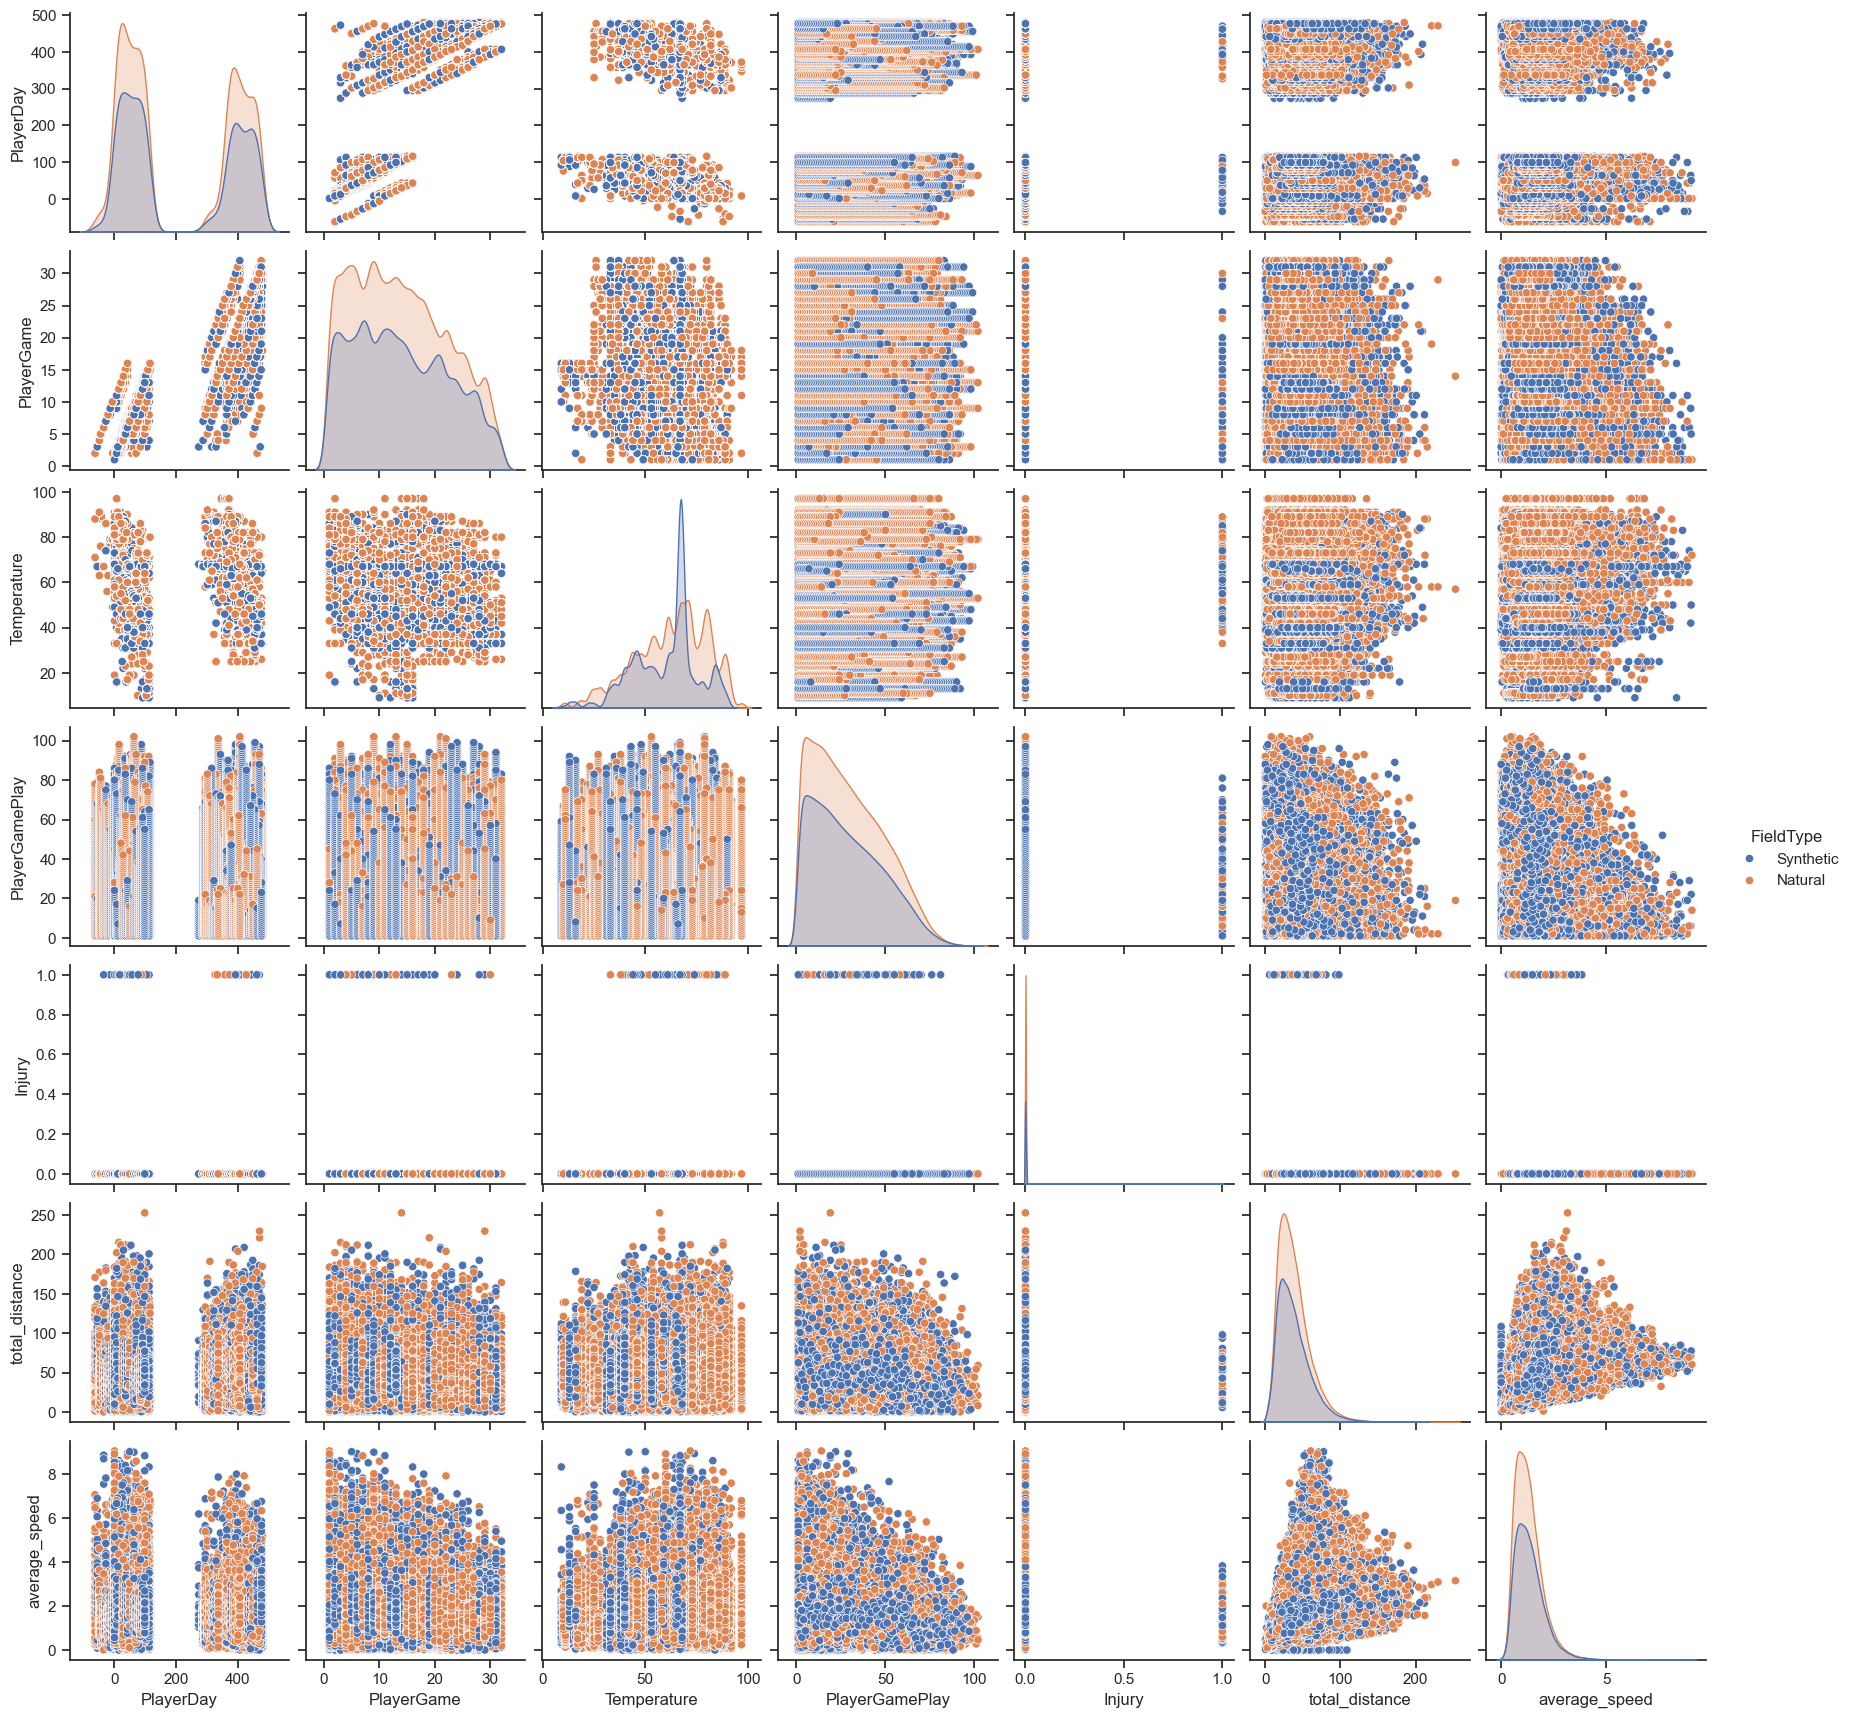

In [58]:
# Scatter plot matrix
sns.set_theme(style="ticks")
sns.pairplot(data, hue="FieldType")

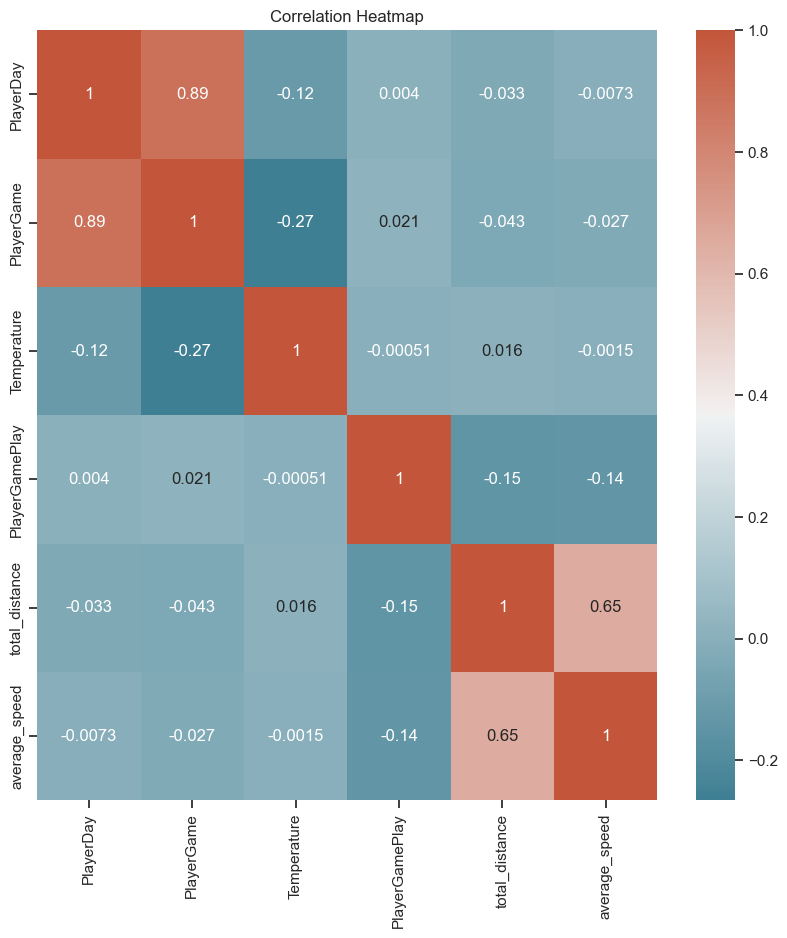

In [59]:
corr_df = data[['PlayerDay', 'PlayerGame','Temperature','PlayerGamePlay',
       'total_distance','average_speed']].corr()

fig = plt.figure(figsize=(10,10))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

In [60]:
# ADD VIF
# Calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
numerical_df = data[['PlayerDay', 'PlayerGame','Temperature','PlayerGamePlay',
       'total_distance','average_speed']]

# 1. Add a constant column to the DataFrame (required for VIF calculation)
X = add_constant(numerical_df)

# 2. Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 3. Drop the constant column from the result
vif = vif[vif["Feature"] != "const"]

# Display VIF values
print(vif)

          Feature       VIF
1       PlayerDay  5.049538
2      PlayerGame  5.362086
3     Temperature  1.159230
4  PlayerGamePlay  1.026804
5  total_distance  1.742907
6   average_speed  1.740567


> All values are acceptable as they don't excede 10. But will remove 'PlayerDay' and 'PlayerGame' as they don't serve purpose later in machine learning.

## One Hot Encoding

In [61]:
# Converting categorical into indicator columns
oh_data = pd.get_dummies(data, columns=['StadiumType', 'FieldType', 'Weather', 'PlayType', 'Position'])

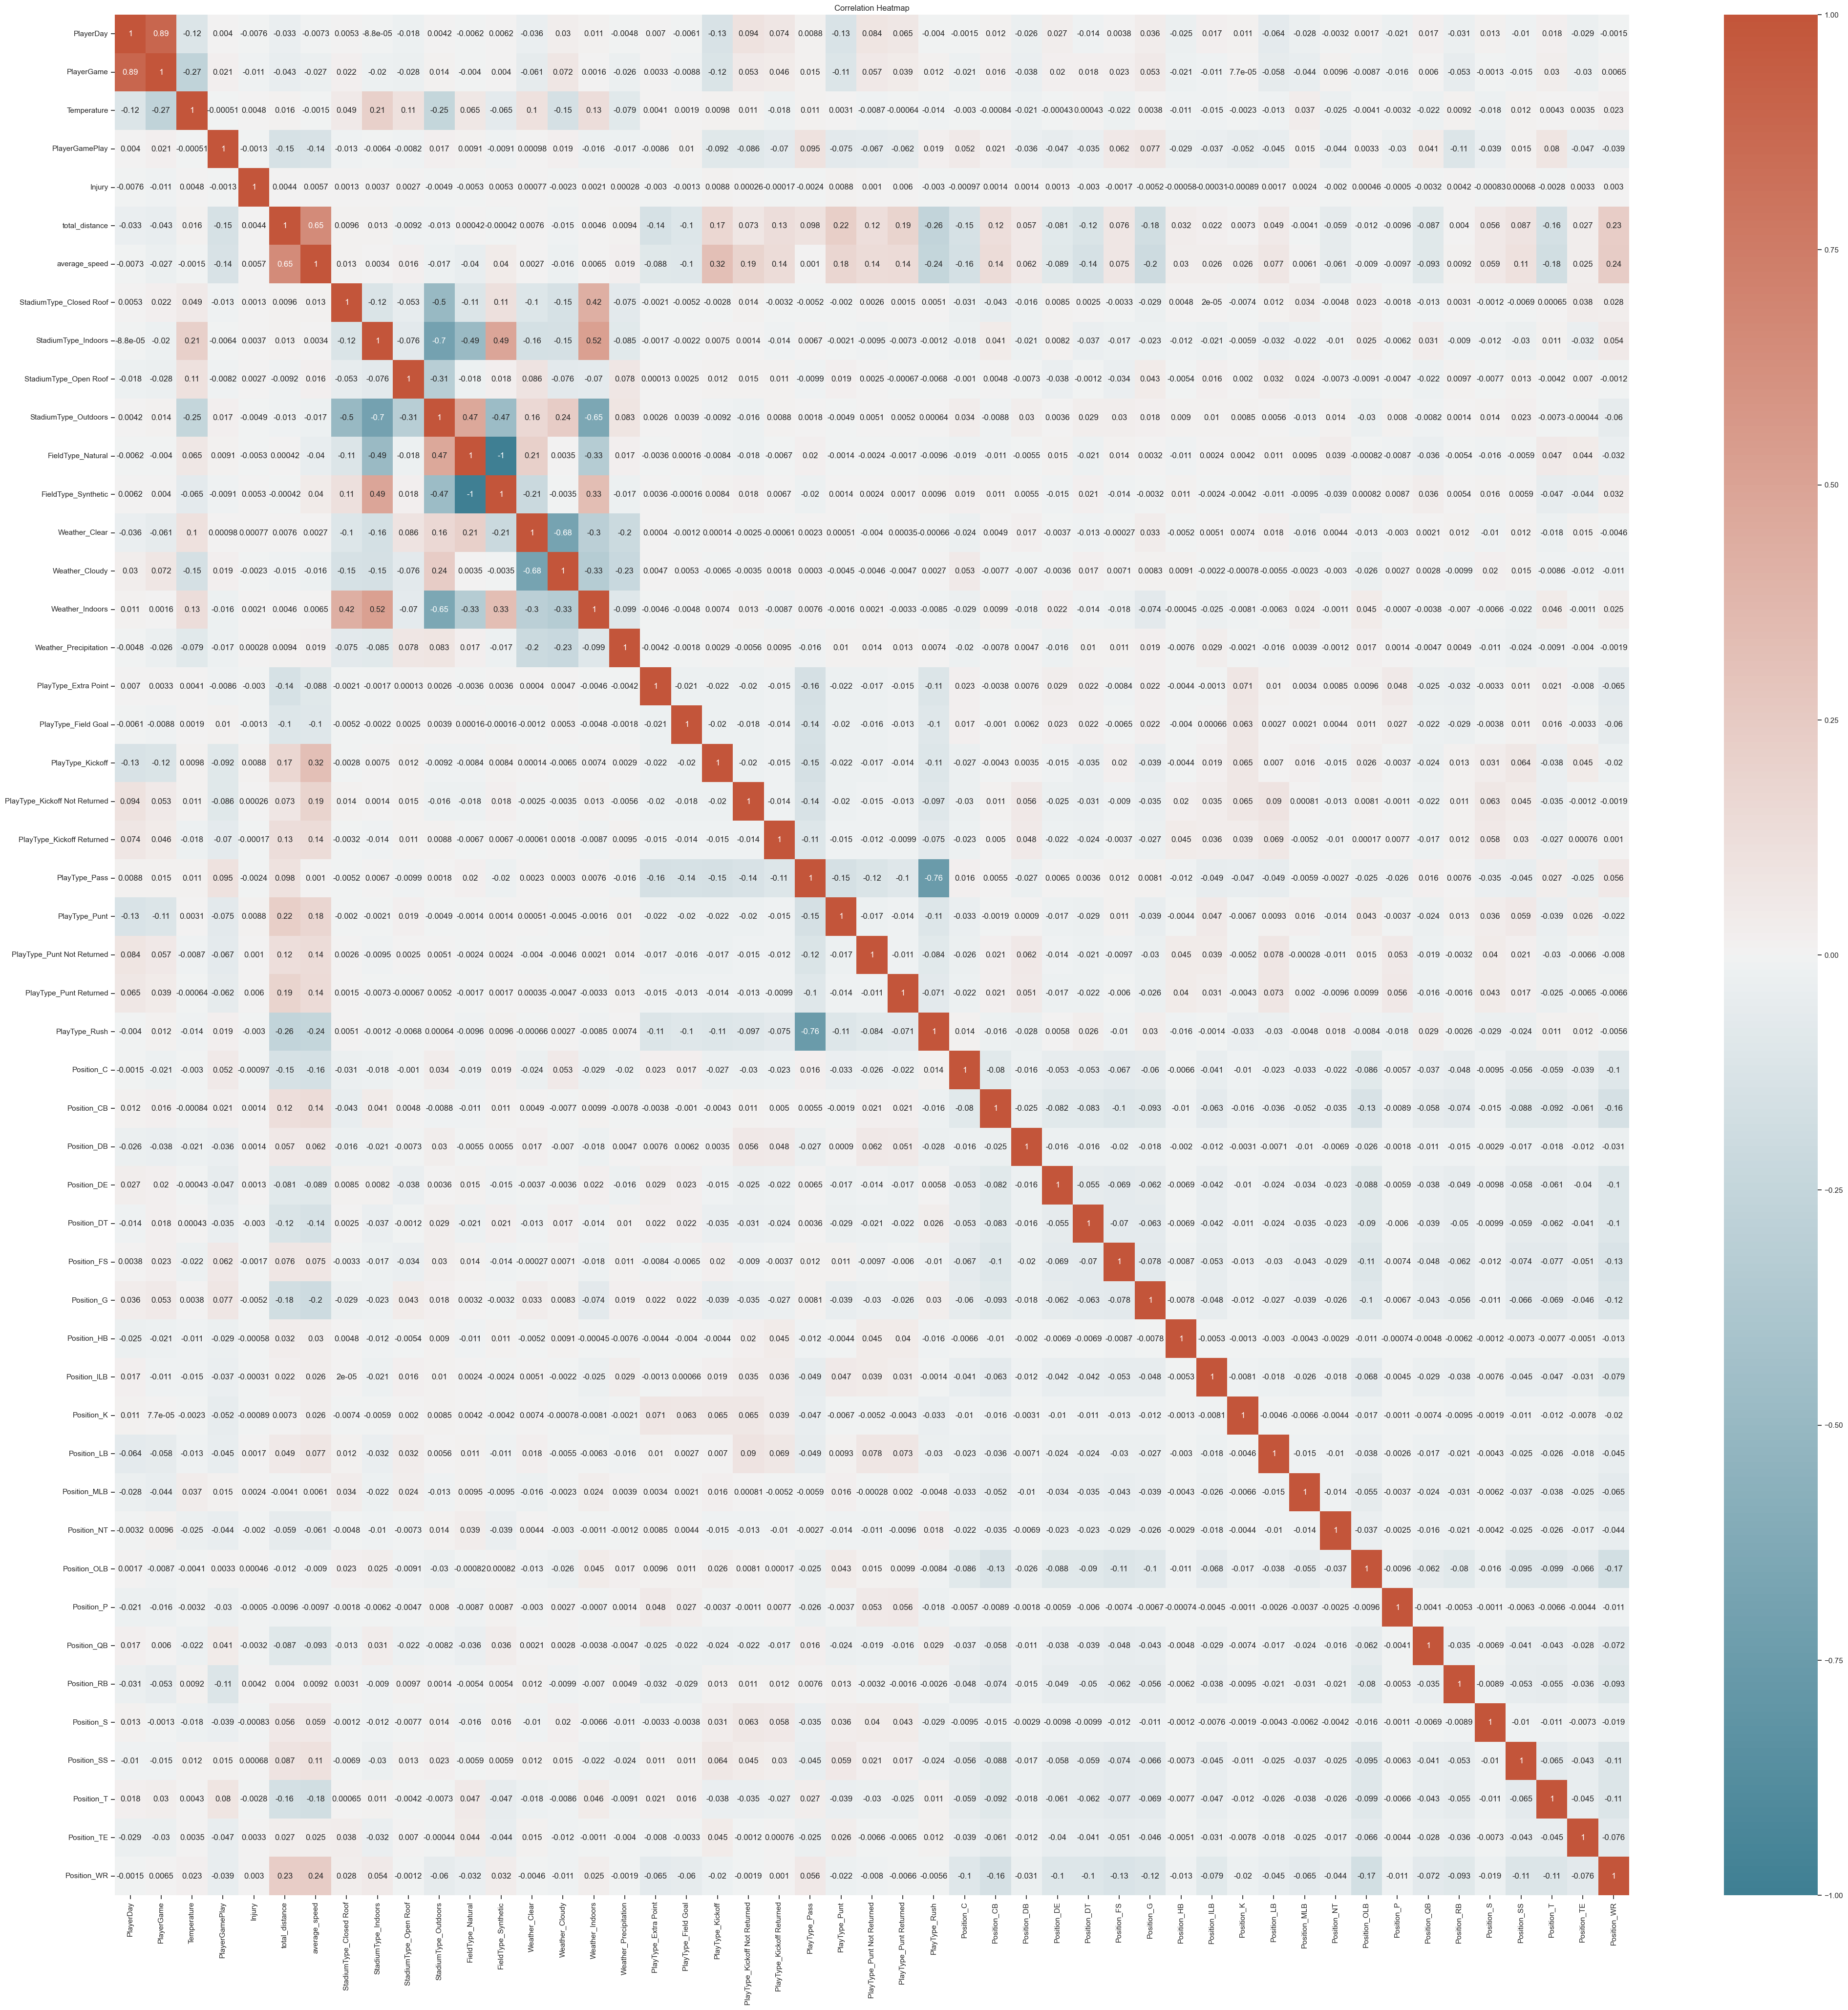

In [62]:
corr_df = oh_data.corr()

fig = plt.figure(figsize=(50,50))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

In [63]:
# Set a threshold for high correlation (absolute value)
threshold = 0.7

# Find feature pairs with high correlation
high_corr_pairs = []

# Iterate over the correlation matrix
for i in range(len(corr_df.columns)):
    for j in range(i + 1, len(corr_df.columns)):
        if abs(corr_df.iloc[i, j]) > threshold:
            feature_1 = corr_df.columns[i]
            feature_2 = corr_df.columns[j]
            correlation_value = corr_df.iloc[i, j]
            high_corr_pairs.append((feature_1, feature_2, correlation_value))

# Convert to DataFrame for better readability
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation Coefficient"])
high_corr_df

Feature 1             Feature 2  Correlation Coefficient
0            PlayerDay            PlayerGame                 0.886659
1  StadiumType_Indoors  StadiumType_Outdoors                -0.702722
2    FieldType_Natural   FieldType_Synthetic                -1.000000
3        PlayType_Pass         PlayType_Rush                -0.757771

#### Removing, PlayerDay, PlayerGame, StadiumType_Outdoors and, FieldType_Synthetic combining PlayType_Pass and PlayType_Rush for the sake of multicollinearity

In [64]:
# Combining pass and rush
oh_data['PlayType_Pass&Rush'] = (oh_data[['PlayType_Pass', 'PlayType_Rush']].any(axis=1)).astype(int)

In [65]:
columns = ['PlayerDay', 'PlayerGame', 'StadiumType_Outdoors', 'FieldType_Synthetic','PlayType_Pass', 'PlayType_Rush']
oh_data.drop(columns, inplace=True, axis=1)

In [66]:
# oh_data.to_csv(r'C:\Users\Anurodh\CSE-805 Project\Charisma\nfl_data.csv', index=False)

In [67]:
# loading dataset
nfl_data = oh_data

## Machine learning

## Class imbalance detection
While data cleaning we relaized there is presence of imbalance in our target variable, where majority were 'Injury' == No. Let's see the proportion and how to treat it.

In [68]:
nfl_data['Injury'].value_counts()

Injury
0.0    266856
1.0       105
Name: count, dtype: int64

In [69]:
# calculating percentage of value counts in target variable 'Injury'
nfl_data['Injury'].value_counts() * 100 / len(nfl_data)

Injury
0.0    99.960668
1.0     0.039332
Name: count, dtype: float64

> **99.96 % No and 0.039 % Yes**. There is a huge imbalance in our target variable and it needs to be adressed. Class imbalance in a target variable significantly affects machine learning predictions by causing models to become biased towards the majority class, leading to poor accuracy when predicting the minority class.

In [70]:
nfl_data.columns

Index(['Temperature', 'PlayerGamePlay', 'Injury', 'total_distance',
       'average_speed', 'StadiumType_Closed Roof', 'StadiumType_Indoors',
       'StadiumType_Open Roof', 'FieldType_Natural', 'Weather_Clear',
       'Weather_Cloudy', 'Weather_Indoors', 'Weather_Precipitation',
       'PlayType_Extra Point', 'PlayType_Field Goal', 'PlayType_Kickoff',
       'PlayType_Kickoff Not Returned', 'PlayType_Kickoff Returned',
       'PlayType_Punt', 'PlayType_Punt Not Returned', 'PlayType_Punt Returned',
       'Position_C', 'Position_CB', 'Position_DB', 'Position_DE',
       'Position_DT', 'Position_FS', 'Position_G', 'Position_HB',
       'Position_ILB', 'Position_K', 'Position_LB', 'Position_MLB',
       'Position_NT', 'Position_OLB', 'Position_P', 'Position_QB',
       'Position_RB', 'Position_S', 'Position_SS', 'Position_T', 'Position_TE',
       'Position_WR', 'PlayType_Pass&Rush'],
      dtype='object')

In [71]:
X = nfl_data[['Temperature', 'PlayerGamePlay','total_distance',
       'average_speed', 'StadiumType_Closed Roof', 'StadiumType_Indoors',
       'StadiumType_Open Roof', 'FieldType_Natural', 'Weather_Clear',
       'Weather_Cloudy', 'Weather_Indoors', 'Weather_Precipitation',
       'PlayType_Extra Point', 'PlayType_Field Goal', 'PlayType_Kickoff',
       'PlayType_Kickoff Not Returned', 'PlayType_Kickoff Returned',
       'PlayType_Punt', 'PlayType_Punt Not Returned', 'PlayType_Punt Returned',
       'Position_C', 'Position_CB', 'Position_DB', 'Position_DE',
       'Position_DT', 'Position_FS', 'Position_G', 'Position_HB',
       'Position_ILB', 'Position_K', 'Position_LB', 'Position_MLB',
       'Position_NT', 'Position_OLB', 'Position_P', 'Position_QB',
       'Position_RB', 'Position_S', 'Position_SS', 'Position_T', 'Position_TE',
       'Position_WR', 'PlayType_Pass&Rush']]

y = nfl_data[['Injury']]

## Test and Train Split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Random Oversampling

In [73]:
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)

In [74]:
# Replace infinities with NaN, then handle them as needed
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(0)  # Fill NaNs if created by infinite replacements

# Replace infinities with NaN, then handle them as needed
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(0)  # Fill NaNs if created by infinite replacements

In [75]:
oversample = SMOTE()
X_trainover, y_trainover = oversample.fit_resample(X_train, y_train)

In [76]:
# Fit the model to generate the data.
oversampled = pd.concat([X_trainover, y_trainover], axis=1)

In [77]:
# calculating percentage of value counts in target variable 'Injury'
oversampled['Injury'].value_counts() * 100 / len(oversampled)

Injury
0.0    50.0
1.0    50.0
Name: count, dtype: float64

### Standardizing columns except one ot encoded ones

In [78]:
scaler = StandardScaler()
columns_to_standardize = ['Temperature', 'PlayerGamePlay', 'total_distance', 'average_speed']

# Standardize only the selected columns
X_train_resampled_standardized = pd.DataFrame(X_trainover, columns=X_train.columns)
X_test_standardized = X_test.copy()

In [79]:
X_train_resampled_standardized[columns_to_standardize] = scaler.fit_transform(X_trainover[columns_to_standardize])
X_test_standardized[columns_to_standardize] = scaler.transform(X_test[columns_to_standardize])

> **The imbalance have been rectified and data has been standardized.**

In [80]:
def metrics_score(y_test, y_pred, model):
    # Related Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')  # Change 'binary' to 'weighted' or 'macro' for multiclass
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plotting Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    model_table = pd.DataFrame([[model, accuracy, 1-recall, recall, precision, f1]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score'])
    
    return model_table

## 1. Logistic Regression

In [81]:
# Apply Logistic Regression
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, penalty = 'l1', solver='liblinear').fit(X_train_resampled_standardized, y_trainover)

C:\Users\chari\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [82]:
y_pred = lg.predict(X_test_standardized)

Accuracy: 0.99
Precision: 0.00
Recall: 0.03
F1-Score: 0.00

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     88058
         1.0       0.00      0.03      0.00        40

    accuracy                           0.99     88098
   macro avg       0.50      0.51      0.50     88098
weighted avg       1.00      0.99      0.99     88098



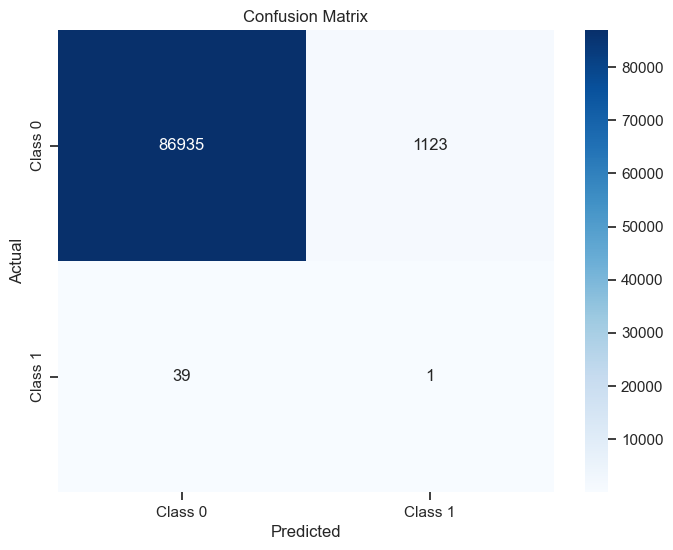

Model  Accuracy  FalseNegRate  Recall  Precision  F1 Score
0  Logistic Regression   0.98681         0.975   0.025    0.00089  0.001718

In [83]:
results = metrics_score(y_test, y_pred,'Logistic Regression')
results

## 2. SVM

In [84]:
from sklearn.svm import SVC, LinearSVC

In [85]:
svm = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=10000, random_state=42).fit(X_train_resampled_standardized, y_trainover)

C:\Users\chari\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
# Make predictions on the test set
y_pred_svm = svm.predict(X_test_standardized)

Accuracy: 0.99
Precision: 0.00
Recall: 0.03
F1-Score: 0.00

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     88058
         1.0       0.00      0.03      0.00        40

    accuracy                           0.99     88098
   macro avg       0.50      0.51      0.50     88098
weighted avg       1.00      0.99      0.99     88098



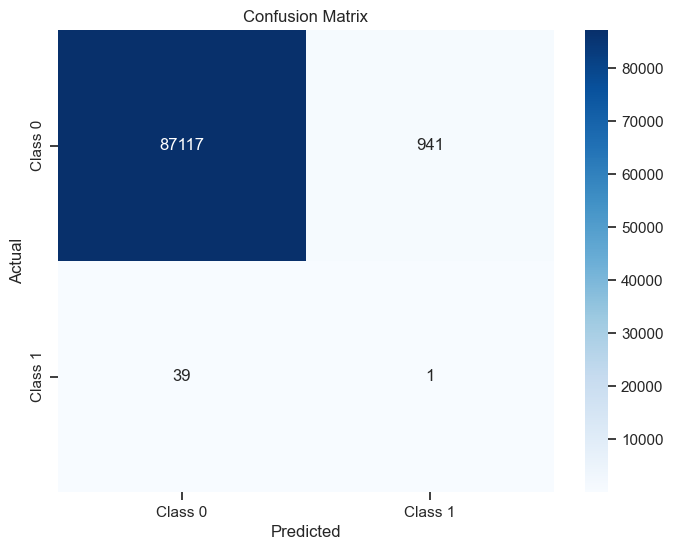

In [87]:
svm_test = metrics_score(y_test,y_pred_svm,'SVM')

In [88]:
results = pd.concat([results, svm_test], ignore_index=True)
results

Model  Accuracy  FalseNegRate  Recall  Precision  F1 Score
0  Logistic Regression  0.986810         0.975   0.025   0.000890  0.001718
1                  SVM  0.988876         0.975   0.025   0.001062  0.002037

## 3. XGBoost

In [89]:
import xgboost as xgb

In [90]:
scale_pos_weight = (len(y_train) / (2 * np.sum(y_train == 1))).item()

# print(f"scale_pos_weight: {scale_pos_weight}, type: {type(scale_pos_weight)}")


C:\Users\chari\anaconda3\envs\ml_env\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [91]:
model = xgb.XGBClassifier(
    booster='gbtree',            # Use tree-based model
    objective='binary:logistic', # Binary classification
    learning_rate=0.01,          # Step size at each iteration
    n_estimators=300,            # Number of boosting rounds
    max_depth=9,                 # Maximum depth of each tree
    min_child_weight=3,          # Minimum sum of instance weight for a child
    gamma=0.2,                   # Minimum loss reduction to make a further partition
    subsample=0.8,               # Fraction of training data used for fitting each tree
    colsample_bytree=0.8,        # Fraction of features used for each tree
    scale_pos_weight=scale_pos_weight,  # Adjusts the weight for imbalanced classes
    eval_metric='logloss',       # Log-loss as the evaluation metric
    tree_method='auto',          # Automatically choose the best tree construction method
    grow_policy='depthwise',     # Use depth-wise splitting for tree construction
    max_leaves=0,                # Limit on the number of leaves (set 0 for no limit)
    lambda_=1.0,                 # L2 regularization term
    alpha=0.5,                   # L1 regularization term
    random_state=42              # Random seed for reproducibility
)

# Train the model
model.fit(X_train_resampled_standardized, y_trainover)

C:\Users\chari\anaconda3\envs\ml_env\lib\site-packages\xgboost\core.py:158: UserWarning: [20:35:03] WARNING: D:\bld\xgboost-split_1738880195977\work\src\learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.5, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None, lambda_=1.0,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, ...)

In [92]:
y_pred_prob = model.predict_proba(X_test_standardized)[:, 1]

In [93]:
y_pred = (y_pred_prob > 0.8).astype(int)
y_test1 = y_test.astype(int)
y_test1 = y_test1.to_numpy()

Accuracy: 0.40
Precision: 0.00
Recall: 0.60
F1-Score: 0.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57     88058
           1       0.00      0.60      0.00        40

    accuracy                           0.40     88098
   macro avg       0.50      0.50      0.28     88098
weighted avg       1.00      0.40      0.57     88098



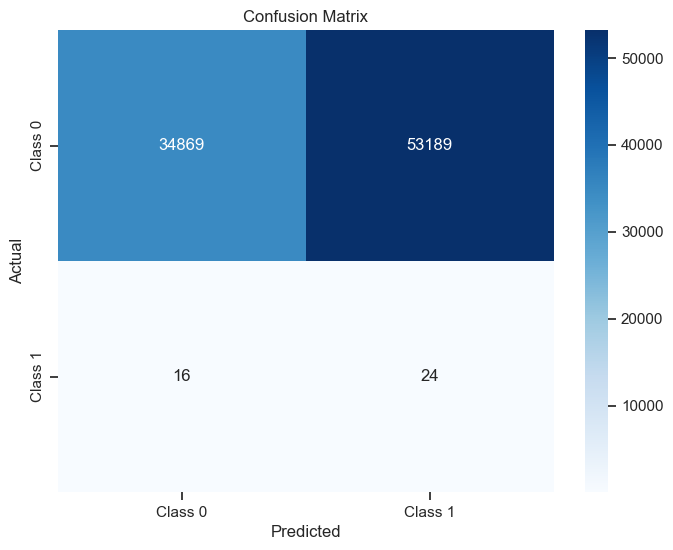

In [94]:
xg_test = metrics_score(y_test1,y_pred,'XGBoost')

In [95]:
results = pd.concat([results,xg_test], ignore_index = True)
results

Model  Accuracy  FalseNegRate  Recall  Precision  F1 Score
0  Logistic Regression  0.986810         0.975   0.025   0.000890  0.001718
1                  SVM  0.988876         0.975   0.025   0.001062  0.002037
2              XGBoost  0.396070         0.400   0.600   0.000451  0.000901

## 4. Neural Networks

In [96]:
# Import libraries

from sklearn.metrics import precision_recall_curve, auc
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
from sklearn.utils import class_weight

In [97]:

model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_resampled_standardized.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [98]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# Learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X = X_train_resampled_standardized.astype(np.float32).values
y = y_trainover.astype(np.float32).values

h1= model.fit(X, y,epochs=15,validation_split=0.1,verbose=1,callbacks=[lr_scheduler,early_stopping])

Epoch 1/15
10058/10058 [==============================] - 35s 3ms/step - loss: 0.0394 - accuracy: 0.9848 - val_loss: 0.0041 - val_accuracy: 0.9986 - lr: 0.0010
Epoch 2/15
10058/10058 [==============================] - 34s 3ms/step - loss: 0.0140 - accuracy: 0.9952 - val_loss: 0.0023 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 3/15
10058/10058 [==============================] - 36s 4ms/step - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.0016 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/15
10058/10058 [==============================] - 35s 3ms/step - loss: 0.0100 - accuracy: 0.9970 - val_loss: 0.0015 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/15
10058/10058 [==============================] - 35s 3ms/step - loss: 0.0089 - accuracy: 0.9974 - val_loss: 0.0020 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 6/15
10058/10058 [==============================] - 35s 3ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0032 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/15
10058/10058 [================

In [99]:
#Predict the response for test dataset
X_test = X_test_standardized.astype(np.float32).values
y_pred_nn = model.predict(X_test)

2754/2754 [==============================] - 5s 2ms/step


In [100]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

Accuracy: 1.00
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     88058
         1.0       0.00      0.00      0.00        40

    accuracy                           1.00     88098
   macro avg       0.50      0.50      0.50     88098
weighted avg       1.00      1.00      1.00     88098



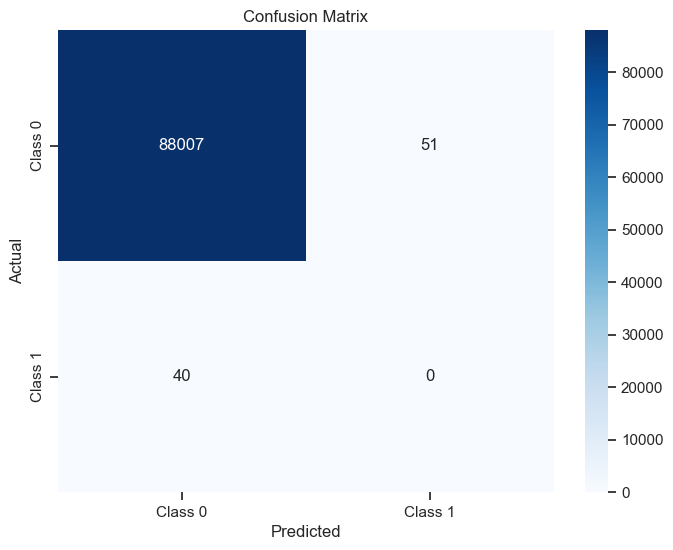

In [101]:
nn_test = metrics_score(y_test,y_pred_nn,'Neural Network ')

In [102]:
results = pd.concat([results, nn_test], ignore_index=True)
results

Model  Accuracy  FalseNegRate  Recall  Precision  F1 Score
0  Logistic Regression  0.986810         0.975   0.025   0.000890  0.001718
1                  SVM  0.988876         0.975   0.025   0.001062  0.002037
2              XGBoost  0.396070         0.400   0.600   0.000451  0.000901
3      Neural Network   0.998967         1.000   0.000   0.000000  0.000000

## 5. Decision Tree

In [103]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Define the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=5)  # You can tune max_depth and other hyperparameters

# Train the classifier on the resampled training data
clf.fit(X_train_resampled_standardized, y_trainover)

# Predict on the test set
y_test_pred = clf.predict(X_test_standardized)

# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Compute accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

Confusion Matrix:
[[76641 11417]
 [   34     6]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93     88058
         1.0       0.00      0.15      0.00        40

    accuracy                           0.87     88098
   macro avg       0.50      0.51      0.47     88098
weighted avg       1.00      0.87      0.93     88098


Accuracy: 87.00%


In [104]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Confusion Matrix for Training Data
cm_train = confusion_matrix(y_test, y_test_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()

# Calculate Metrics
accuracy_train = (TP_train + TN_train) / (TP_train + TN_train + FP_train + FN_train)
precision_train = TP_train / (TP_train + FP_train) if (TP_train + FP_train) != 0 else 0
recall_train = TP_train / (TP_train + FN_train) if (TP_train + FN_train) != 0 else 0
specificity_train = TN_train / (TN_train + FP_train) if (TN_train + FP_train) != 0 else 0
f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train) if (precision_train + recall_train) != 0 else 0

# Print Results for Training Data
print(f"Training Data Metrics:")
print(f"Confusion Matrix:\n{cm_train}")
print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"Recall: {recall_train:.2f}")
print(f"Specificity: {specificity_train:.2f}")
print(f"F1 Score: {f1_score_train:.2f}")

Training Data Metrics:
Confusion Matrix:
[[76641 11417]
 [   34     6]]
Accuracy: 0.87
Precision: 0.00
Recall: 0.15
Specificity: 0.87
F1 Score: 0.00


In [105]:
# Predict on test data
y_test_pred = clf.predict(X_test)

# Evaluate performance
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


[[76641 11417]
 [   34     6]]
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93     88058
         1.0       0.00      0.15      0.00        40

    accuracy                           0.87     88098
   macro avg       0.50      0.51      0.47     88098
weighted avg       1.00      0.87      0.93     88098



C:\Users\chari\anaconda3\envs\ml_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(



Test Data Metrics:


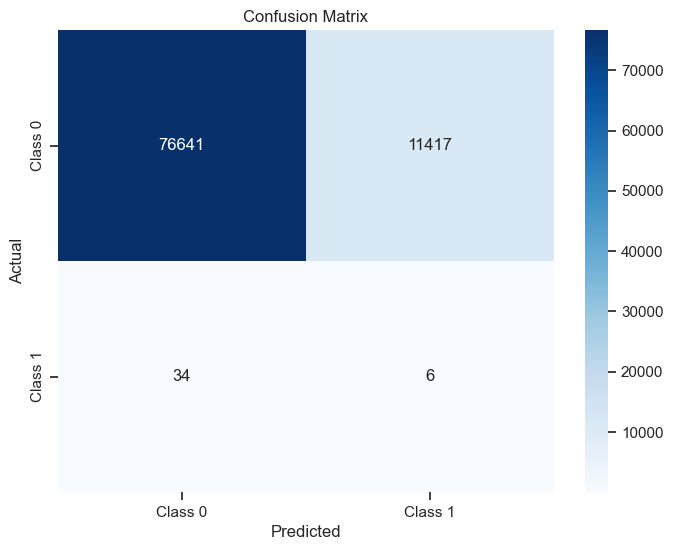

Accuracy: 0.87
Precision: 0.00
Recall: 0.15
Specificity: 0.87
F1 Score: 0.00


In [106]:
# Confusion Matrix for Test Data
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()

# Calculate Metrics
accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test)
precision_test = TP_test / (TP_test + FP_test) if (TP_test + FP_test) != 0 else 0
recall_test = TP_test / (TP_test + FN_test) if (TP_test + FN_test) != 0 else 0
specificity_test = TN_test / (TN_test + FP_test) if (TN_test + FP_test) != 0 else 0
f1_score_test = 2 * (precision_test * recall_test) / (precision_test + recall_test) if (precision_test + recall_test) != 0 else 0

# Print Results for Test Data
print(f"\nTest Data Metrics:")
# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f"Accuracy: {accuracy_test:.2f}")
print(f"Precision: {precision_test:.2f}")
print(f"Recall: {recall_test:.2f}")
print(f"Specificity: {specificity_test:.2f}")
print(f"F1 Score: {f1_score_test:.2f}")

In [107]:
mod1e = 'Decision Tree'
model_table = pd.DataFrame([[mod1e, accuracy_test, 1-recall_test, recall_test, precision_test, f1_score_test]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score'])

In [108]:
results = pd.concat([results, model_table], ignore_index=True)
results

Model  Accuracy  FalseNegRate  Recall  Precision  F1 Score
0  Logistic Regression  0.986810         0.975   0.025   0.000890  0.001718
1                  SVM  0.988876         0.975   0.025   0.001062  0.002037
2              XGBoost  0.396070         0.400   0.600   0.000451  0.000901
3      Neural Network   0.998967         1.000   0.000   0.000000  0.000000
4        Decision Tree  0.870020         0.850   0.150   0.000525  0.001047

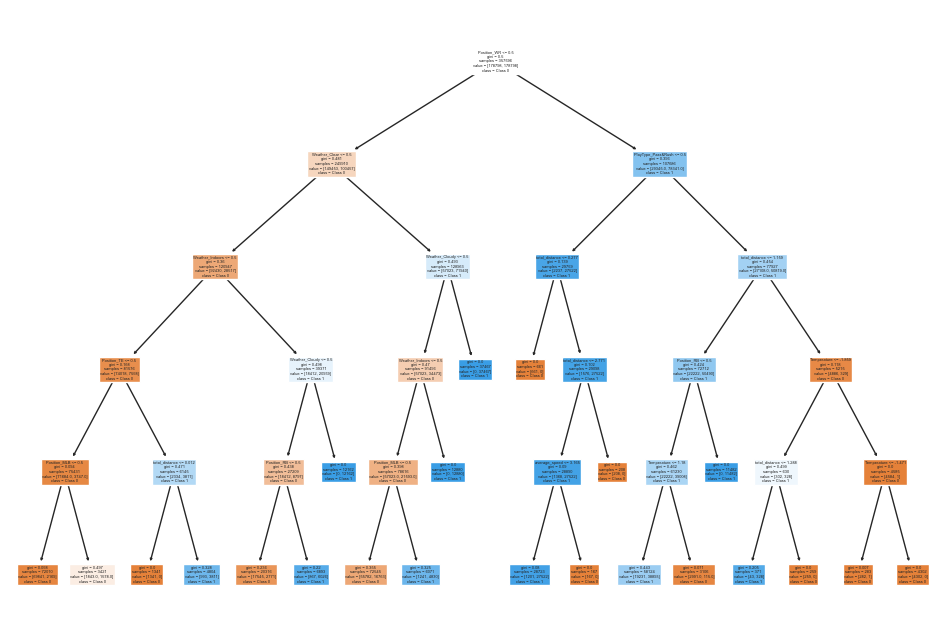

In [109]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(12, 8))
tree.plot_tree(clf, 
               feature_names=X_train_resampled_standardized.columns, 
               class_names=['Class 0', 'Class 1'], 
               filled=True)
plt.show()


In [110]:
feature_importances = clf.feature_importances_
for name, importance in zip(X_train_resampled_standardized.columns, feature_importances):
    print(f"{name}: {importance}")

Temperature: 0.024386640892126367
PlayerGamePlay: 0.0
total_distance: 0.06397002896156717
average_speed: 0.0027990763161996235
StadiumType_Closed Roof: 0.0
StadiumType_Indoors: 0.0
StadiumType_Open Roof: 0.0
FieldType_Natural: 0.0
Weather_Clear: 0.1188633997860482
Weather_Cloudy: 0.2602518929007895
Weather_Indoors: 0.20117823015227726
Weather_Precipitation: 0.0
PlayType_Extra Point: 0.0
PlayType_Field Goal: 0.0
PlayType_Kickoff: 0.0
PlayType_Kickoff Not Returned: 0.0
PlayType_Kickoff Returned: 0.0
PlayType_Punt: 0.0
PlayType_Punt Not Returned: 0.0
PlayType_Punt Returned: 0.0
Position_C: 0.0
Position_CB: 0.0
Position_DB: 0.0
Position_DE: 0.0
Position_DT: 0.0
Position_FS: 0.0
Position_G: 0.0
Position_HB: 0.0
Position_ILB: 0.0
Position_K: 0.0
Position_LB: 0.0
Position_MLB: 0.043928266968447774
Position_NT: 0.0
Position_OLB: 0.0
Position_P: 0.0
Position_QB: 0.0
Position_RB: 0.07483114233984327
Position_S: 0.0
Position_SS: 0.0
Position_T: 0.0
Position_TE: 0.03395807609834795
Position_WR: 0.

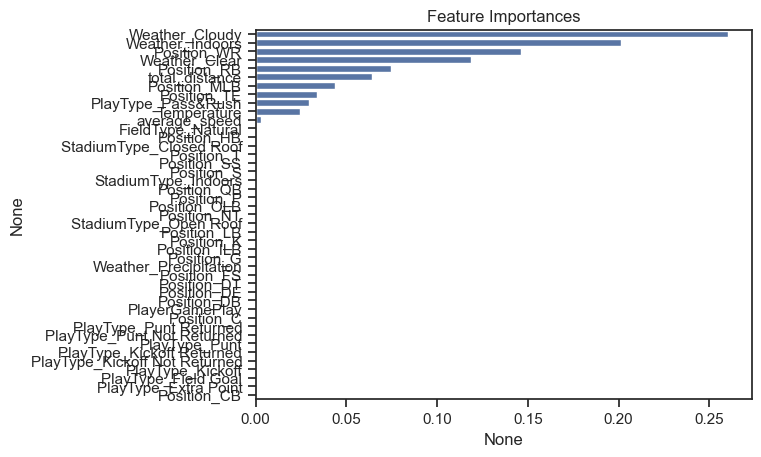

In [111]:
import pandas as pd
import seaborn as sns

feature_importances = pd.Series(clf.feature_importances_, index=X_train_resampled_standardized.columns)
feature_importances = feature_importances.sort_values(ascending=False)
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances')
plt.show()


## 6. Naive Bayesian

In [112]:
from sklearn.naive_bayes import GaussianNB

In [113]:
nb_model = GaussianNB().fit(X_train_resampled_standardized, y_trainover)

C:\Users\chari\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [114]:
# Predictions
y_pred_nb = nb_model.predict(X_test_standardized)

Accuracy: 0.14
Precision: 0.00
Recall: 0.97
F1-Score: 0.00

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.14      0.25     88058
         1.0       0.00      0.97      0.00        40

    accuracy                           0.14     88098
   macro avg       0.50      0.56      0.13     88098
weighted avg       1.00      0.14      0.25     88098



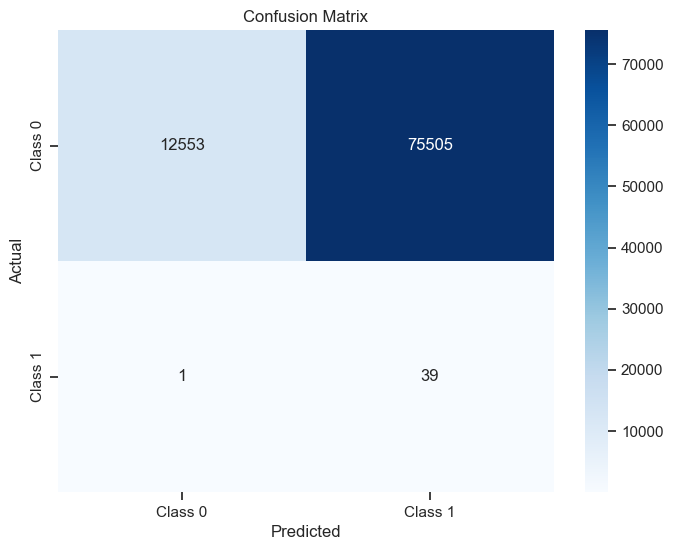

In [115]:
nb_test = metrics_score(y_test,y_pred_nb,'Naive Bayesian')

In [116]:
results = pd.concat([results, nb_test], ignore_index=True)
results

Model  Accuracy  FalseNegRate  Recall  Precision  F1 Score
0  Logistic Regression  0.986810         0.975   0.025   0.000890  0.001718
1                  SVM  0.988876         0.975   0.025   0.001062  0.002037
2              XGBoost  0.396070         0.400   0.600   0.000451  0.000901
3      Neural Network   0.998967         1.000   0.000   0.000000  0.000000
4        Decision Tree  0.870020         0.850   0.150   0.000525  0.001047
5       Naive Bayesian  0.142932         0.025   0.975   0.000516  0.001032

## 7. Random Forest

In [117]:
from sklearn.ensemble import RandomForestClassifier

C:\Users\chari\anaconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 1.00
Precision: 0.08
Recall: 0.03
F1-Score: 0.04

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     88058
         1.0       0.08      0.03      0.04        40

    accuracy                           1.00     88098
   macro avg       0.54      0.51      0.52     88098
weighted avg       1.00      1.00      1.00     88098



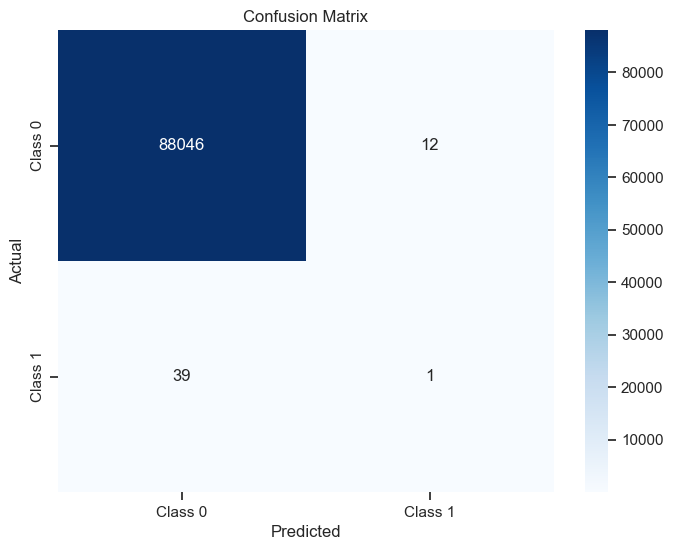

In [118]:
# Create Random Forest classifer object
rf = RandomForestClassifier(random_state = 1, class_weight= 'balanced', criterion= 'entropy')

# Train random forest
rf.fit(X_train_resampled_standardized, y_trainover)

#Predict the response for test dataset
y_pred_rf = rf.predict(X_test_standardized)

rf_test = metrics_score(y_test,y_pred_rf,'Random Forest')

In [119]:
results = pd.concat([results,rf_test], ignore_index = True)
results

Model  Accuracy  FalseNegRate  Recall  Precision  F1 Score
0  Logistic Regression  0.986810         0.975   0.025   0.000890  0.001718
1                  SVM  0.988876         0.975   0.025   0.001062  0.002037
2              XGBoost  0.396070         0.400   0.600   0.000451  0.000901
3      Neural Network   0.998967         1.000   0.000   0.000000  0.000000
4        Decision Tree  0.870020         0.850   0.150   0.000525  0.001047
5       Naive Bayesian  0.142932         0.025   0.975   0.000516  0.001032
6        Random Forest  0.999421         0.975   0.025   0.076923  0.037736

## 6. Neural Network Class weights

In [120]:

y_train1 = y_train.values.flatten().astype(int)  # Convert to 1D numpy array and cast to int
classes = np.unique(y_train1)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train1)
class_weight_dict = dict(enumerate(class_weights))


In [121]:

model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_resampled_standardized.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [122]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# Learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train_resampled_standardized = X_train_resampled_standardized.astype(np.float32)
y_trainover = y_trainover.astype(np.float32)


h2= model.fit(X_train_resampled_standardized,y_trainover,batch_size=20,epochs=15,validation_split=0.1,verbose=1,callbacks=[lr_scheduler,early_stopping], class_weight=class_weight_dict)

Epoch 1/15
16092/16092 [==============================] - 56s 3ms/step - loss: 1.9973 - accuracy: 0.5962 - val_loss: 1.7435e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/15
16092/16092 [==============================] - 55s 3ms/step - loss: 0.8802 - accuracy: 0.7012 - val_loss: 1.2901e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/15
16092/16092 [==============================] - 56s 4ms/step - loss: 0.8262 - accuracy: 0.7320 - val_loss: 2.4411e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/15
16092/16092 [==============================] - 58s 4ms/step - loss: 0.8339 - accuracy: 0.7527 - val_loss: 9.5975e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/15
16092/16092 [==============================] - 59s 4ms/step - loss: 0.6023 - accuracy: 0.8067 - val_loss: 2.4365e-06 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 6/15
16092/16092 [==============================] - 58s 4ms/step - loss: 0.5943 - accuracy: 0.8011 - val_loss: 1.7876e-06 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 7/

In [123]:
print(type(model))

<class 'keras.engine.sequential.Sequential'>


In [124]:
#Predict the response for test dataset
X_test = X_test_standardized.fillna(0).astype(np.float32).values

y_pred_nnW = model.predict(X_test)


2754/2754 [==============================] - 5s 2ms/step


In [125]:
for i in range(len(y_test)):
    if y_pred_nnW[i]>0.5:
        y_pred_nnW[i]=1 
    else:
        y_pred_nnW[i]=0

Accuracy: 0.88
Precision: 0.00
Recall: 0.15
F1-Score: 0.00

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94     88058
         1.0       0.00      0.15      0.00        40

    accuracy                           0.88     88098
   macro avg       0.50      0.51      0.47     88098
weighted avg       1.00      0.88      0.93     88098



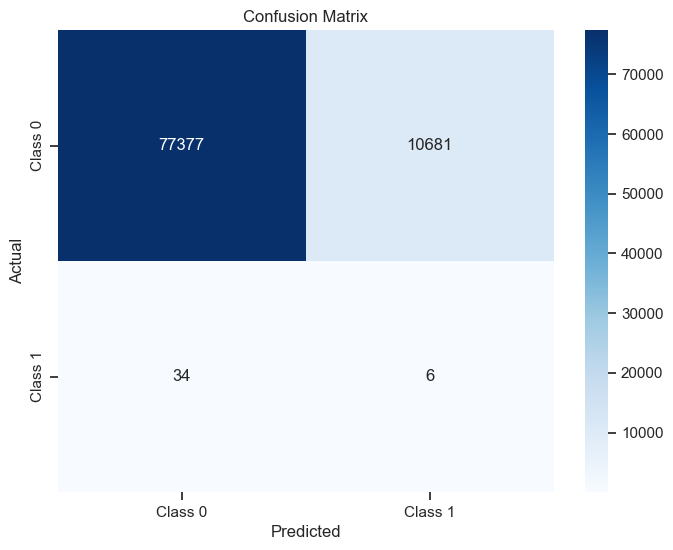

In [126]:
nn_Weight_test = metrics_score(y_test,y_pred_nnW,'Neural Network Weighted')

In [127]:
results = pd.concat([results, nn_Weight_test], ignore_index=True)
results

Model  Accuracy  FalseNegRate  Recall  Precision  \
0      Logistic Regression  0.986810         0.975   0.025   0.000890   
1                      SVM  0.988876         0.975   0.025   0.001062   
2                  XGBoost  0.396070         0.400   0.600   0.000451   
3          Neural Network   0.998967         1.000   0.000   0.000000   
4            Decision Tree  0.870020         0.850   0.150   0.000525   
5           Naive Bayesian  0.142932         0.025   0.975   0.000516   
6            Random Forest  0.999421         0.975   0.025   0.076923   
7  Neural Network Weighted  0.878374         0.850   0.150   0.000561   

   F1 Score  
0  0.001718  
1  0.002037  
2  0.000901  
3  0.000000  
4  0.001047  
5  0.001032  
6  0.037736  
7  0.001119